In [60]:
import json
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from catboost import CatBoostClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

In [61]:
def flatten_dict(d, parent_key='', sep=':'):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

def get_dataframes(folder, inclusion_rules=None):
    if inclusion_rules is None:
        inclusion_rules = []
    filenames = [
        filename
        for filename in os.listdir(f"features/{folder}")
        if all(inclusion_rule in filename for inclusion_rule in inclusion_rules)
    ]

    dataframes = []
    for filename in filenames:
        # print(filename)
        with open(f"features/{folder}/{filename}", mode="r", encoding="utf-8") as file:
            features = json.loads(file.read())
            features = flatten_dict(features)
            for feature in features:
                # if feature == "plv:C3_F4_delta":
                #     pass
                if "annotations" not in feature:
                    if max(features[feature]) != min(features[feature]):
                        # features[feature] = sps.zscore(features[feature])
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            features[feature] = np.nan_to_num(sps.zscore(features[feature]), nan=0)
                    else:
                        features[feature] = np.zeros_like(features[feature])
            dataframes.append(pd.DataFrame(features))

    # df = pd.concat(dataframes, ignore_index=True).dropna()
    # for key in df.keys():
    #     if "annotations" in key:
    #         df[key] = df[key].astype(int)

    return dataframes

In [62]:
def merge_data(dfs):
    X = pd.concat(dfs, axis=0, ignore_index=True).dropna()

    y = pd.to_numeric(X["annotations:main"]).values

    annotations_cols = [col for col in X.columns if col.startswith("annotations")]
    X = X.drop(columns=annotations_cols)

    return X, y

In [63]:
def train_val_test_split(dfs, val_n, test_n):
    random.seed(42)
    indices = list(range(len(dfs)))
    random.shuffle(indices)

    test_indices = indices[:test_n]
    val_indices = indices[test_n:val_n + test_n]
    train_indices = indices[val_n + test_n:]

    train_dfs = [dfs[i] for i in train_indices]
    val_dfs = [dfs[i] for i in val_indices]
    test_dfs = [dfs[i] for i in test_indices]

    X_train, y_train = merge_data(train_dfs)
    X_val, y_val = merge_data(val_dfs)
    X_test, y_test = merge_data(test_dfs)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [64]:
def translate_feature_names(feature_names):
    TRANSLATION_RULES = [
        ("delta", "дельта"),
        ("theta", "тета"),
        ("alpha", "альфа"),
        ("beta", "бета"),
        ("gamma", "гамма"),
        ("psd:", "[PSD] "),
        ("-", " "),
        ("psd_ratio:", "[отн-е PSD] "),
        ("coh:", "[когер.] "),
        ("plv:", "[PLV] "),
        ("lzc", "[LZC] "),
        ("S:", "[энтроп. К.-С.] "),
        ("Lambda:", "[мера Л.] "),
        (":median", "(бин. по медиане)"),
        (":3:", "(3 инт-ла) "),
        (":4:", "(4 инт-ла) "),
        (":5:", "(5 инт-лов) "),
        (":6:", "(6 инт-лов) "),
        ("spatial4", "(4 инт-ла)"),
        ("spatial6", "(6 инт-лов)"),
        ("spatial10", "(10 инт-лов)"),
        ("spatial14", "(14 инт-лов)"),
        ("spatial20", "(20 инт-лов)"),
        ("spatial24", "(24 инт-ла)"),
        ("temporal3", "(врем., окно 3)"),
        ("temporal4", "(врем., окно 4)"),
        (":", " "),
        ("_", " "),
    ]

    feature_names = np.array(feature_names, dtype="str")
    for rule_from, rule_to in TRANSLATION_RULES:
        feature_names = np.char.replace(feature_names, rule_from, rule_to)

    return feature_names

### ISRUC-Sleep

In [6]:
dfs = get_dataframes(
    "isruc-sleep",
    ["part2", "s3"]
)
len(dfs)

10

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=1,
    test_n=2
)

In [8]:
path = "models/isruc-s3.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

pretrained


In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       275
           1       0.30      0.53      0.38        51
           2       0.70      0.81      0.75       362
           3       1.00      0.75      0.86       506
           5       0.88      0.88      0.88       188

    accuracy                           0.81      1382
   macro avg       0.75      0.78      0.75      1382
weighted avg       0.85      0.81      0.82      1382



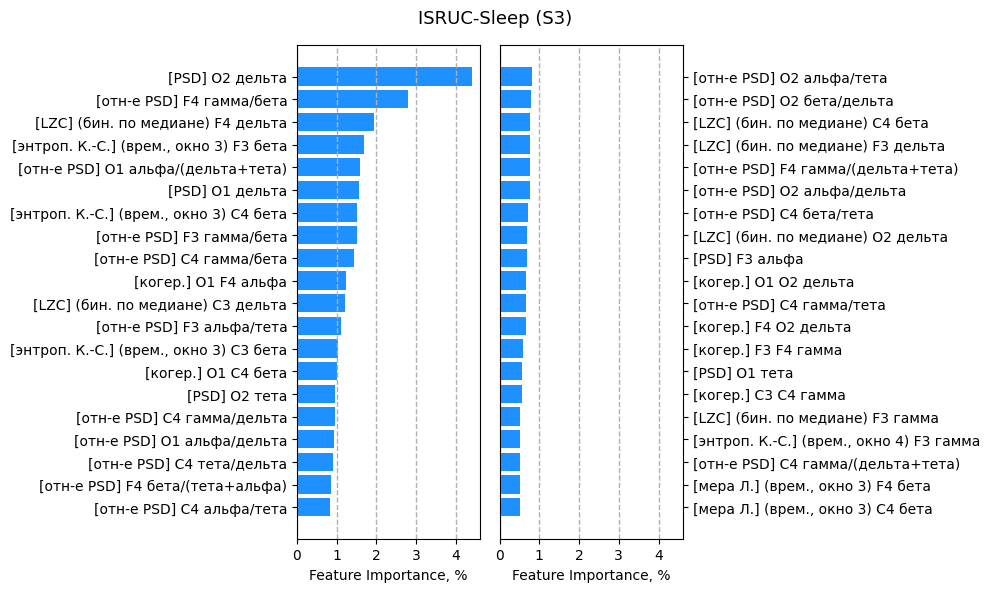

In [10]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 1))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 1))

plt.suptitle("ISRUC-Sleep (S3)", fontsize=13)

plt.tight_layout()
plt.savefig("plots/isruc-sleep/feature_importance_s3.png")
plt.show()

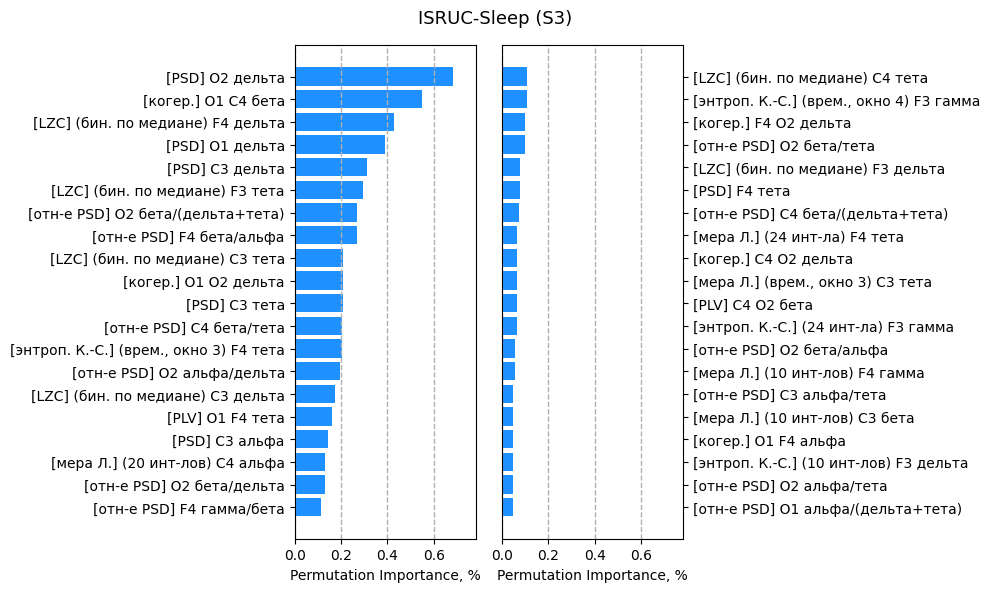

In [11]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Permutation Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.1])
ax1.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.1))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Permutation Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.1])
ax2.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.1))

plt.suptitle("ISRUC-Sleep (S3)", fontsize=13)

plt.tight_layout()
plt.savefig("plots/isruc-sleep/perm_importance_s3.png")
plt.show()

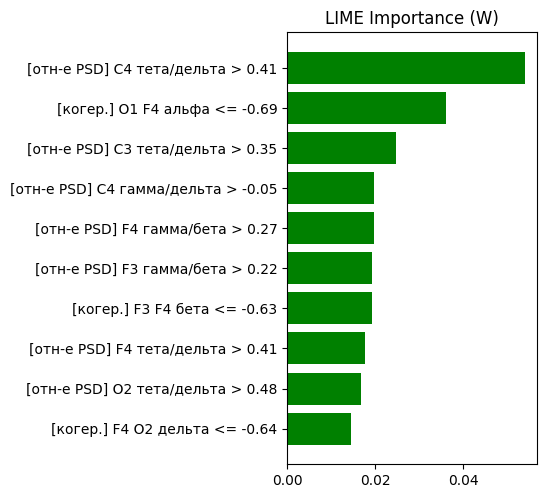

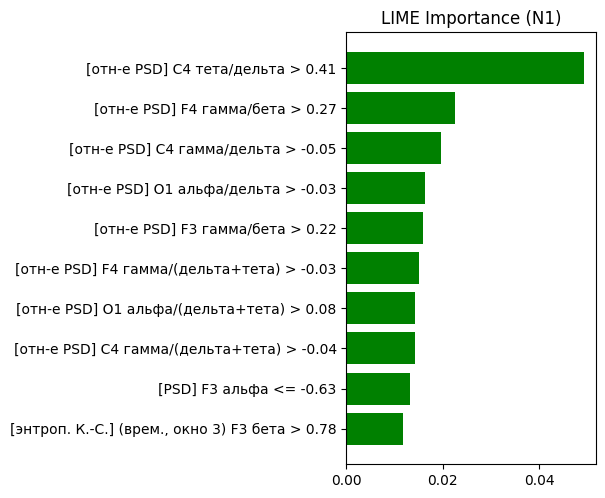

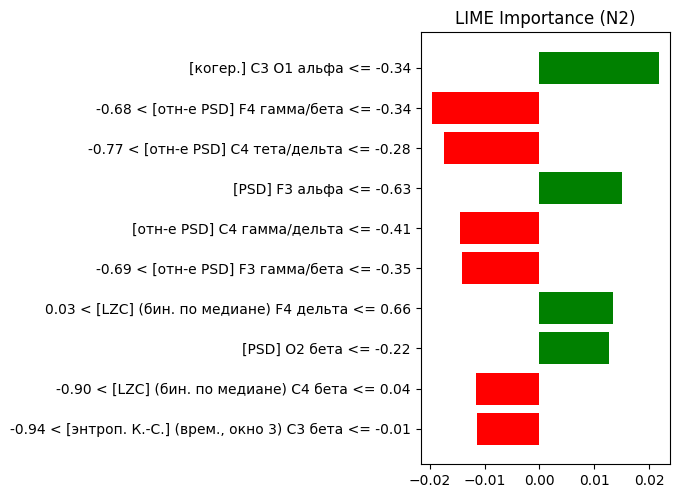

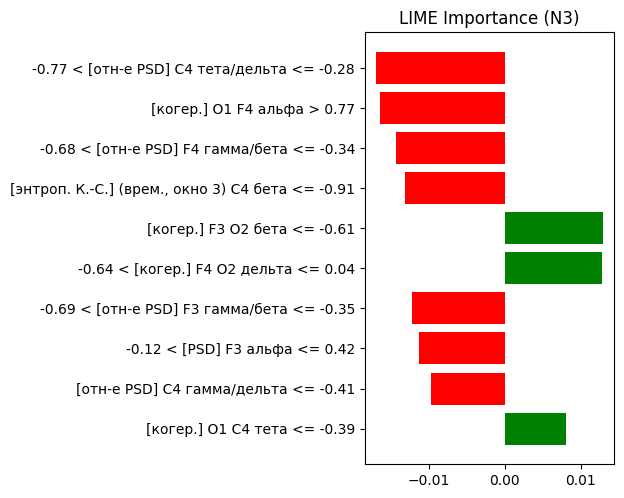

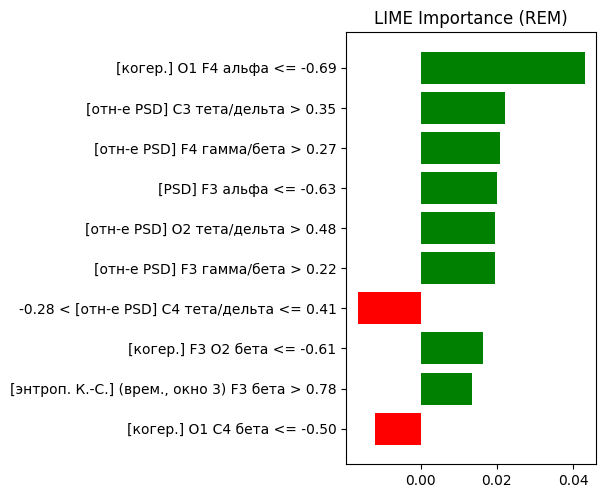

In [12]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = []
for class_label in unique_classes:
    class_samples = X_test[y_pred == class_label]
    random_sample = class_samples.sample(n=1, random_state=42)
    random_samples.append(random_sample)

for sample, stage in zip(
    random_samples,
    ["W", "N1", "N2", "N3", "REM"]
):
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance ({stage})")
    # plt.tight_layout()
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/isruc-sleep/lime-{stage}.png")
    plt.show()

In [13]:
dfs = get_dataframes(
    "isruc-sleep",
    ["part2"]
)
len(dfs)

20

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=2,
    test_n=4
)

In [15]:
path = "models/isruc-all.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

0:	learn: 1.5231244	test: 1.5321769	best: 1.5321769 (0)	total: 700ms	remaining: 11m 39s
50:	learn: 0.4809201	test: 0.7667764	best: 0.7667764 (50)	total: 31.5s	remaining: 9m 45s
100:	learn: 0.3307486	test: 0.6822807	best: 0.6822807 (100)	total: 1m 8s	remaining: 10m 5s
150:	learn: 0.2661662	test: 0.6530820	best: 0.6530820 (150)	total: 1m 39s	remaining: 9m 21s
200:	learn: 0.2305434	test: 0.6332754	best: 0.6332754 (200)	total: 2m 2s	remaining: 8m 7s
250:	learn: 0.2043898	test: 0.6277209	best: 0.6276078 (248)	total: 2m 23s	remaining: 7m 6s
300:	learn: 0.1872359	test: 0.6252466	best: 0.6251748 (298)	total: 2m 45s	remaining: 6m 25s
350:	learn: 0.1724099	test: 0.6200983	best: 0.6189290 (342)	total: 3m 6s	remaining: 5m 44s
400:	learn: 0.1609139	test: 0.6151942	best: 0.6148082 (393)	total: 3m 29s	remaining: 5m 12s
450:	learn: 0.1515863	test: 0.6138888	best: 0.6134358 (419)	total: 3m 50s	remaining: 4m 40s
500:	learn: 0.1429458	test: 0.6127457	best: 0.6123100 (465)	total: 4m 14s	remaining: 4m 13s


In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       465
           1       0.27      0.37      0.31       140
           2       0.90      0.83      0.86       803
           3       0.95      0.95      0.95       502
           5       0.74      0.63      0.68       344

    accuracy                           0.82      2254
   macro avg       0.74      0.75      0.74      2254
weighted avg       0.84      0.82      0.83      2254



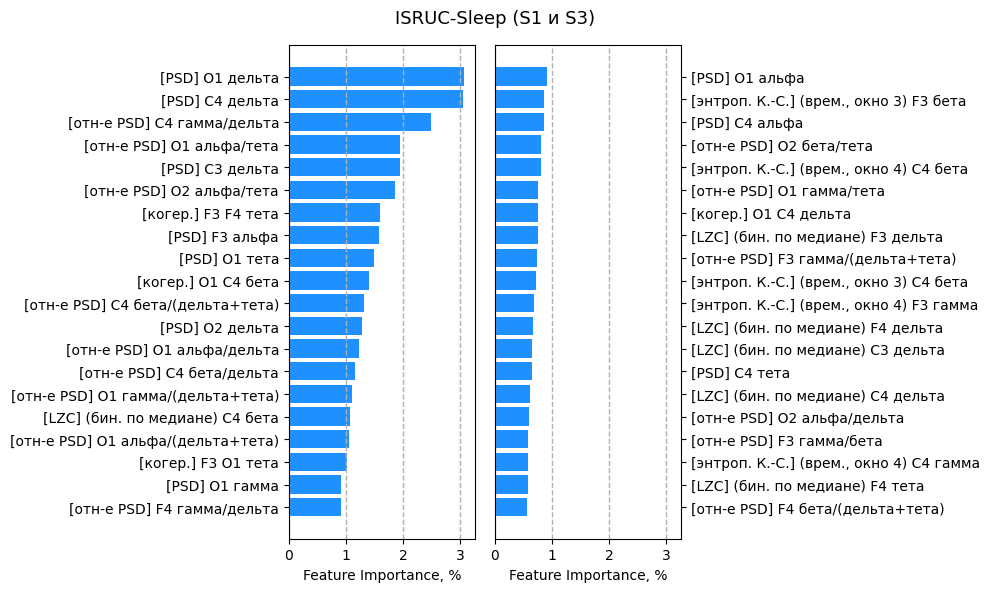

In [17]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 1))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 1))

plt.suptitle("ISRUC-Sleep (S1 и S3)", fontsize=13)

plt.tight_layout()
plt.savefig("plots/isruc-sleep/feature_importance_all.png")
plt.show()

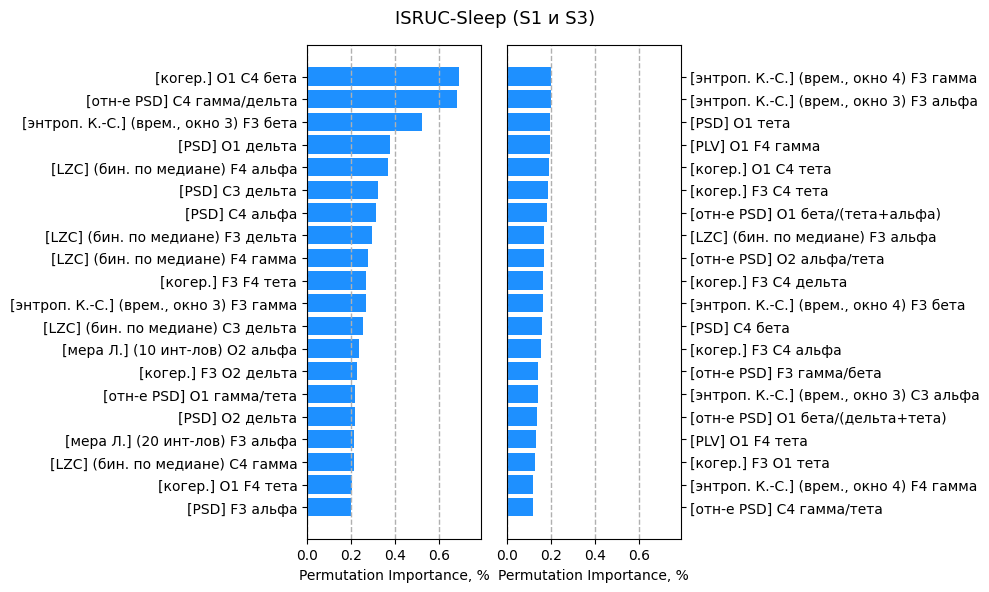

In [20]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Permutation Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.1])
ax1.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.1))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Permutation Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.1])
ax2.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.2))

plt.suptitle("ISRUC-Sleep (S1 и S3)", fontsize=13)

plt.tight_layout()
plt.savefig("plots/isruc-sleep/perm_importance_all.png")
plt.show()

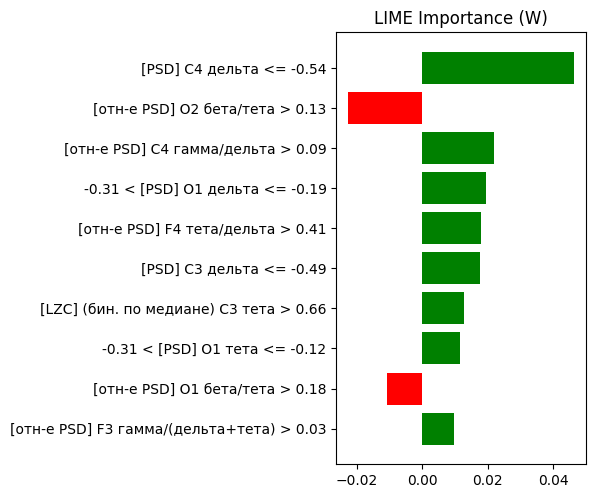

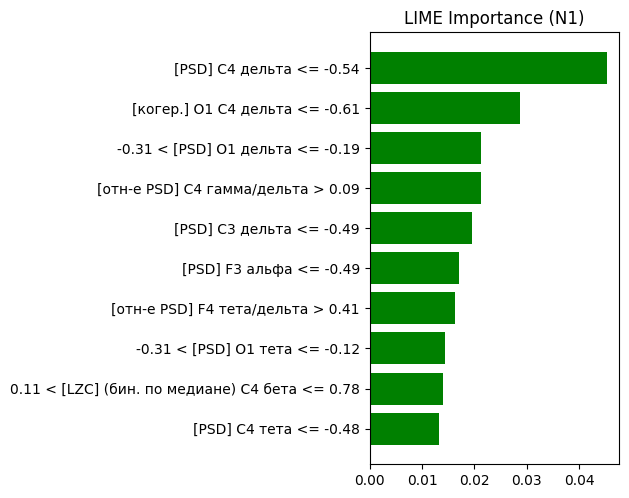

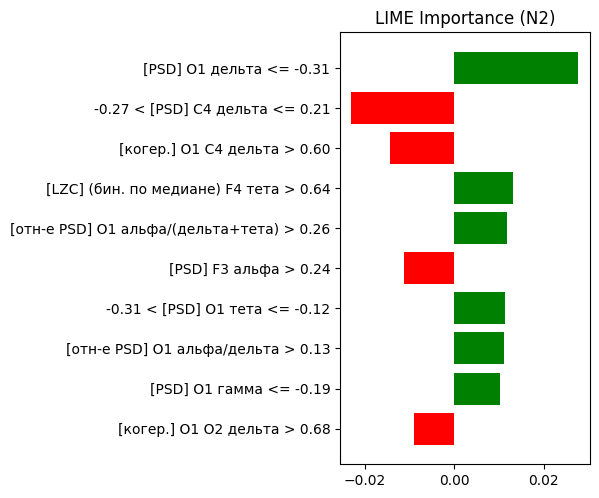

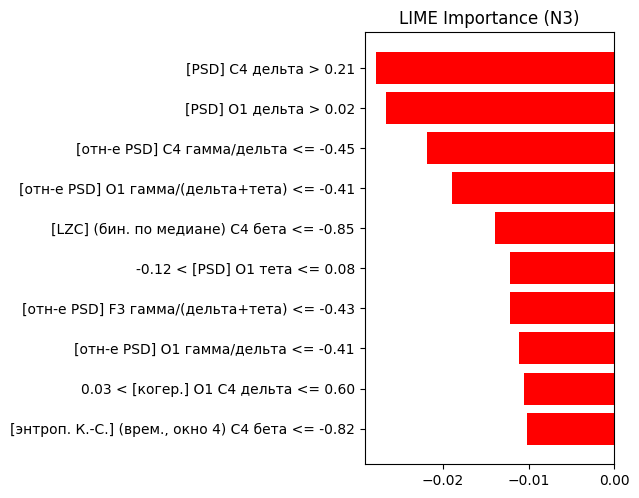

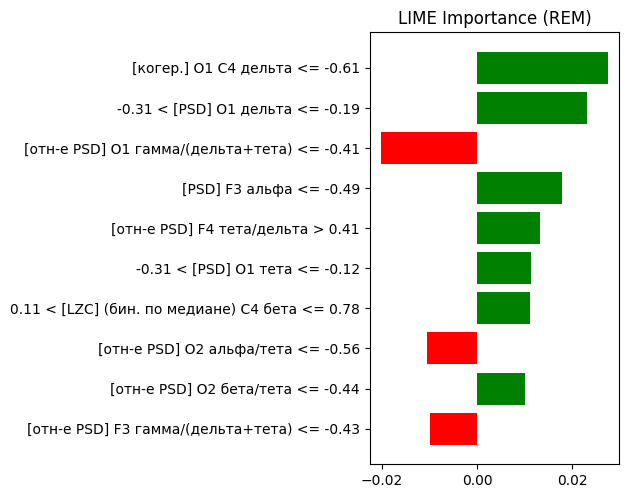

In [19]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = []
for class_label in unique_classes:
    class_samples = X_test[y_pred == class_label]
    random_sample = class_samples.sample(n=1, random_state=42)
    random_samples.append(random_sample)

for sample, stage in zip(
    random_samples,
    ["W", "N1", "N2", "N3", "REM"]
):
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance ({stage})")
    # plt.tight_layout()
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/isruc-sleep/lime_all-{stage}.png")
    plt.show()

### Sleep-EDF

In [21]:
dfs = get_dataframes(
    "sleep_edf_database_expanded",
    ["part2"]
)
len(dfs)

16

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=1,
    test_n=2
)

In [23]:
path = "models/sleep-edf.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

0:	learn: 1.5726746	test: 1.5781641	best: 1.5781641 (0)	total: 137ms	remaining: 2m 17s
50:	learn: 1.2156777	test: 1.3073989	best: 1.3073989 (50)	total: 12.9s	remaining: 4m
100:	learn: 1.1642633	test: 1.3025555	best: 1.3016271 (93)	total: 19s	remaining: 2m 49s
150:	learn: 1.1316265	test: 1.2990087	best: 1.2990087 (150)	total: 25.4s	remaining: 2m 23s
200:	learn: 1.1016463	test: 1.2914284	best: 1.2914284 (200)	total: 32s	remaining: 2m 7s
250:	learn: 1.0700463	test: 1.2889535	best: 1.2867625 (247)	total: 44.1s	remaining: 2m 11s
300:	learn: 1.0451633	test: 1.2861664	best: 1.2856221 (294)	total: 52.1s	remaining: 2m 1s
350:	learn: 1.0199392	test: 1.2831258	best: 1.2831258 (350)	total: 1m 9s	remaining: 2m 9s
400:	learn: 0.9992647	test: 1.2801032	best: 1.2800227 (399)	total: 1m 23s	remaining: 2m 5s
450:	learn: 0.9822057	test: 1.2785648	best: 1.2780726 (446)	total: 1m 41s	remaining: 2m 3s
500:	learn: 0.9642758	test: 1.2782413	best: 1.2777989 (469)	total: 1m 53s	remaining: 1m 52s
Stopped by overf

In [24]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       603
           1       0.00      0.00      0.00        77
           2       0.47      0.81      0.60       867
           3       0.44      0.03      0.05       258
           5       0.35      0.08      0.13       491

    accuracy                           0.53      2296
   macro avg       0.39      0.34      0.30      2296
weighted avg       0.48      0.53      0.45      2296



C:\Users\Raman\PycharmProjects\diploma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Raman\PycharmProjects\diploma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Raman\PycharmProjects\diploma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

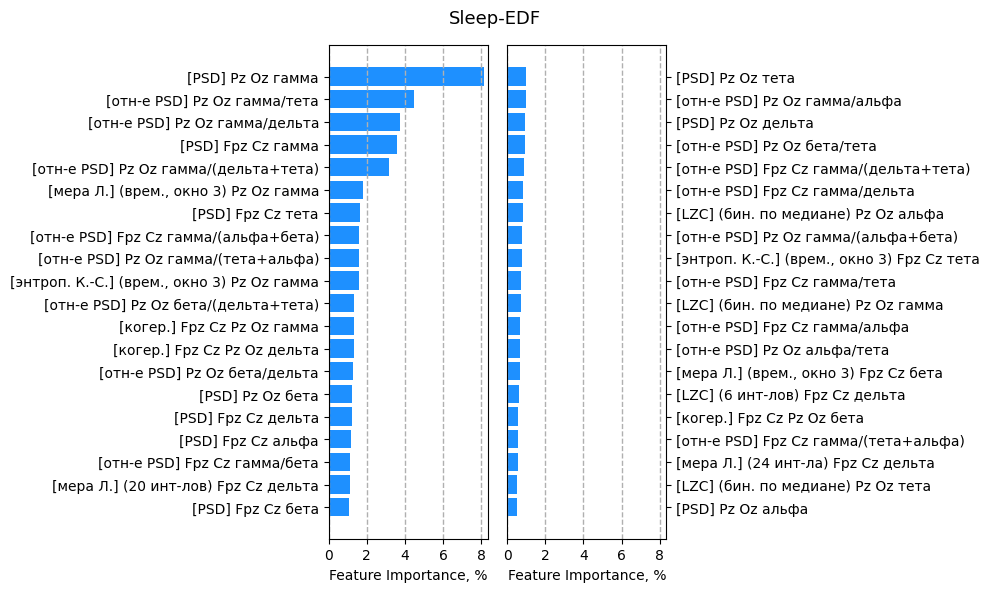

In [25]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 1, 2))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 1, 2))

plt.suptitle("Sleep-EDF", fontsize=13)

plt.tight_layout()
plt.savefig("plots/sleep_edf_database_expanded/feature_importance.png")
plt.show()

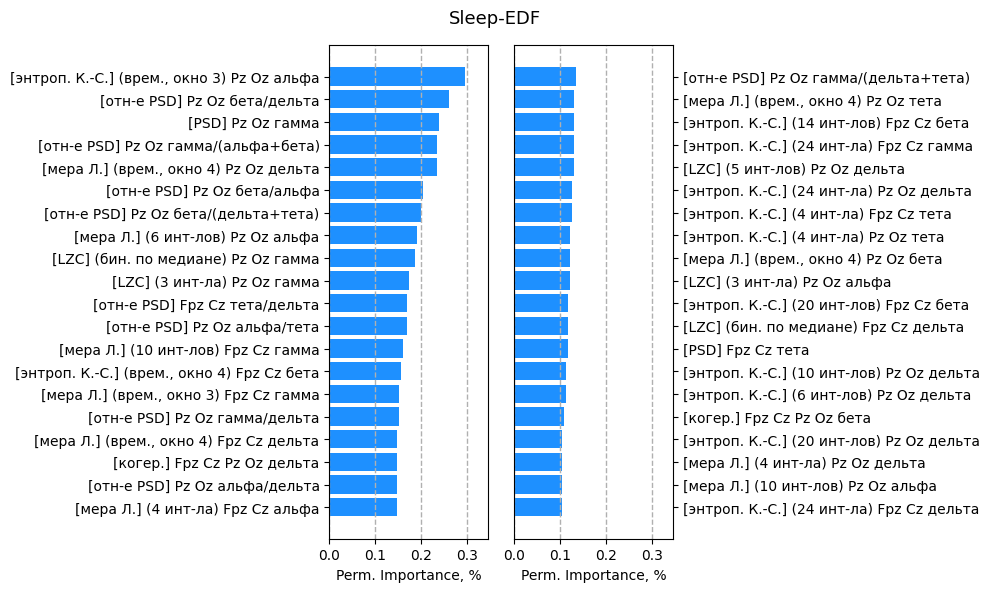

In [35]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Perm. Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.05])
ax1.set_xticks([0, 0.1, 0.2, 0.3])

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Perm. Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.05])
ax2.set_xticks([0, 0.1, 0.2, 0.3])

plt.suptitle("Sleep-EDF", fontsize=13)

plt.tight_layout()
plt.savefig("plots/sleep_edf_database_expanded/perm_importance.png")
plt.show()

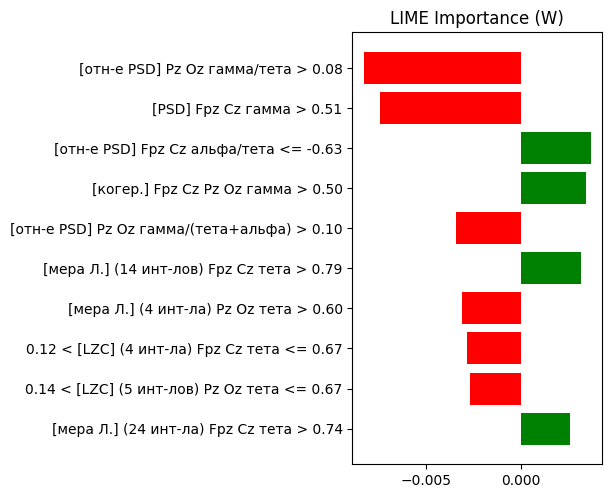

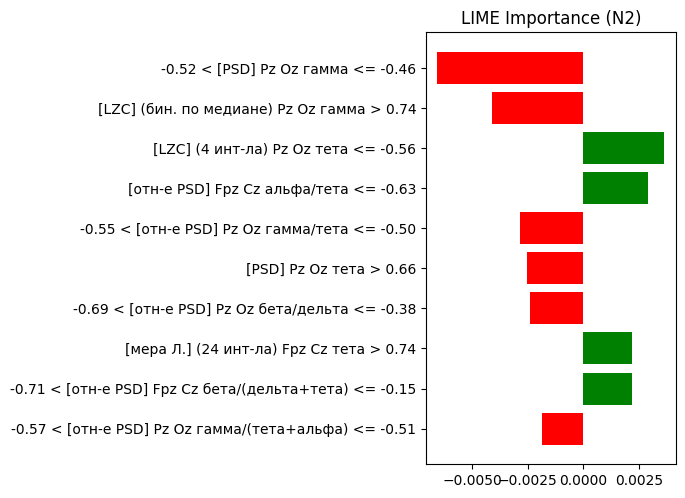

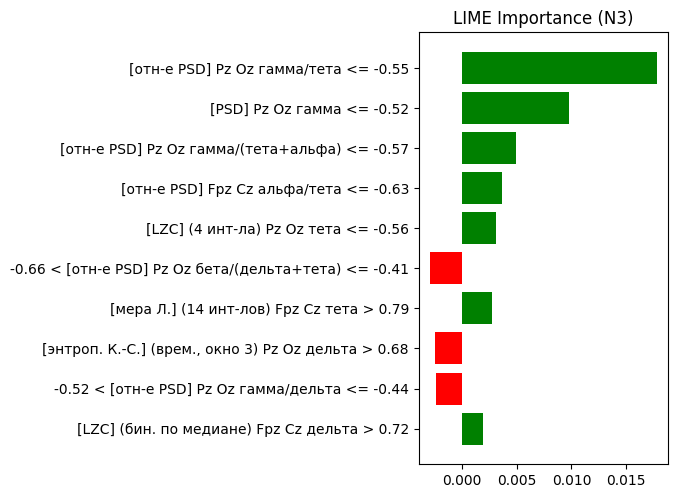

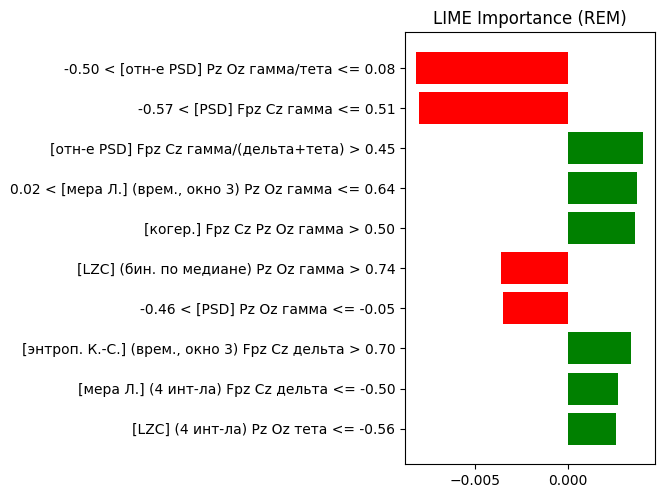

In [31]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = []
for class_label in unique_classes:
    class_samples = X_test[y_pred == class_label]
    random_sample = class_samples.sample(n=1, random_state=42)
    random_samples.append(random_sample)

for sample, stage in zip(
    random_samples,
    ["W", "N2", "N3", "REM"]
):
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance ({stage})")
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/sleep_edf_database_expanded/lime-{stage}.png")
    plt.show()

### EEGMAT

In [65]:
dfs = get_dataframes(
    "eegmat",
    ["part2"]
)
len(dfs)

36

In [66]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=4,
    test_n=10
)

In [67]:
path = "models/eegmat.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

pretrained


In [68]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        59
           1       0.80      0.60      0.69        20

    accuracy                           0.86        79
   macro avg       0.84      0.77      0.80        79
weighted avg       0.86      0.86      0.85        79



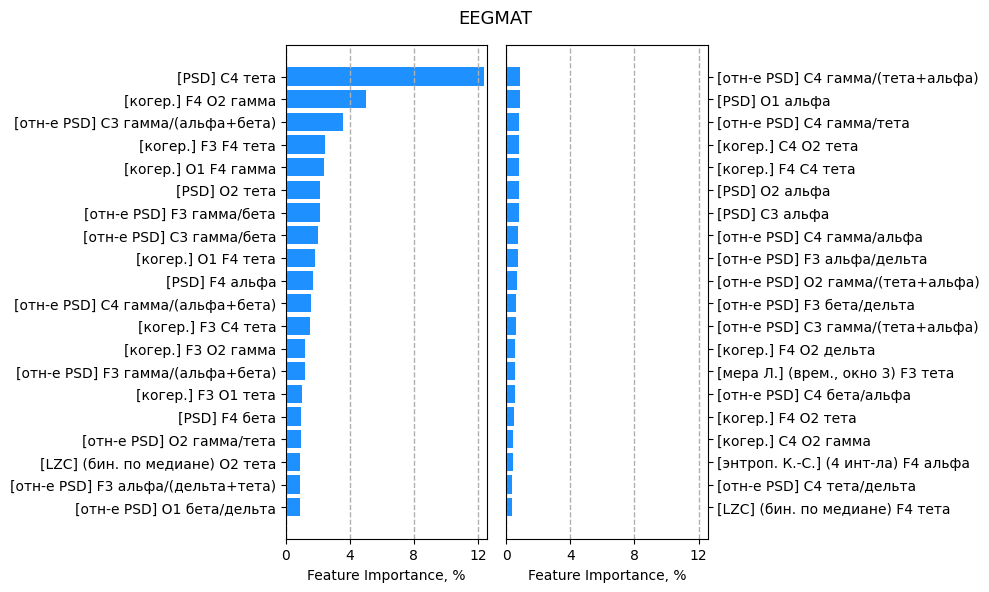

In [69]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 1, 4))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 1, 4))

plt.suptitle("EEGMAT", fontsize=13)

plt.tight_layout()
plt.savefig("plots/eegmat/feature_importance.png")
plt.show()

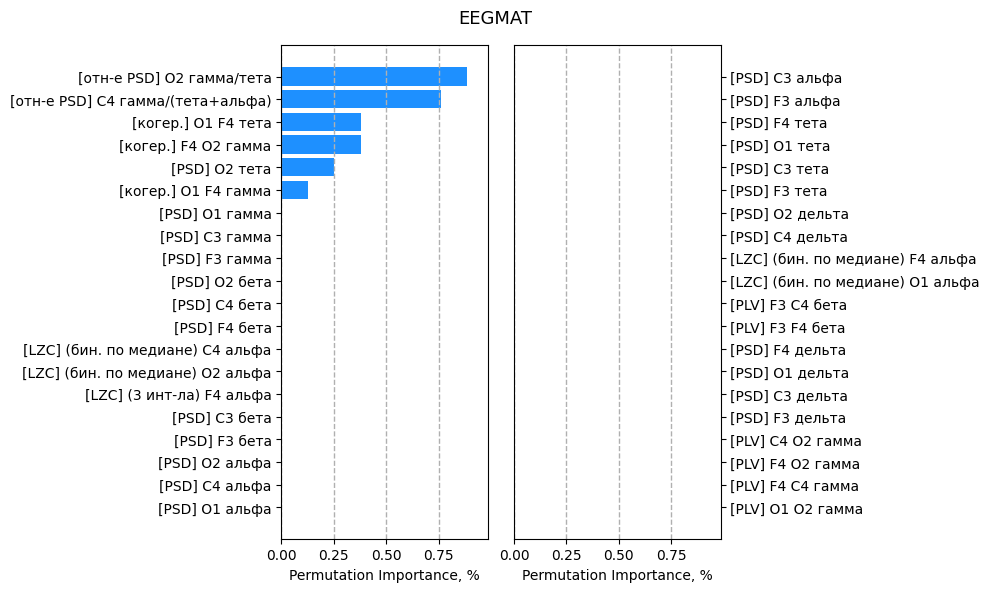

In [70]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Permutation Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.1])
ax1.set_xticks = np.arange(0, max(sorted_importance) + 0.1, 0.1)

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Permutation Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.1])
ax2.set_xticks = np.arange(0, max(sorted_importance) + 0.1, 0.1)

plt.suptitle("EEGMAT", fontsize=13)

plt.tight_layout()
plt.savefig("plots/eegmat/perm_importance.png")
plt.show()

Стадия: [1]


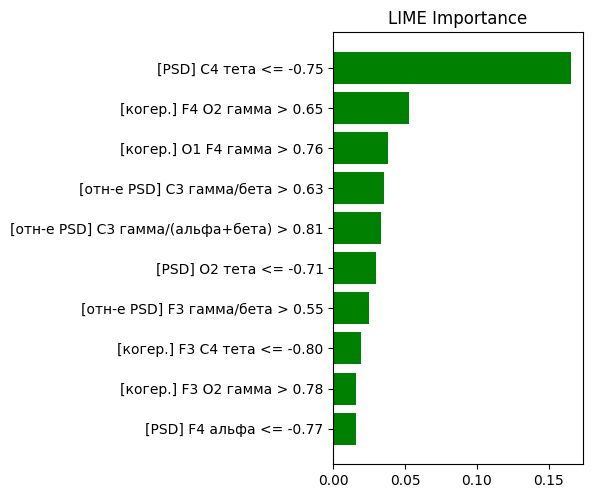

In [81]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = [X_test.sample(n=1, random_state=42)]
print(f"Стадия: {y_test[[random_samples[0].index[0]]]}")

for sample in random_samples:
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance")
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/eegmat/lime.png")
    plt.show()

### SPIS

In [82]:
dfs = get_dataframes(
    "spis",
    ["part2"]
)
len(dfs)

10

In [83]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=1,
    test_n=2
)

In [84]:
path = "models/spis.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

pretrained


In [85]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



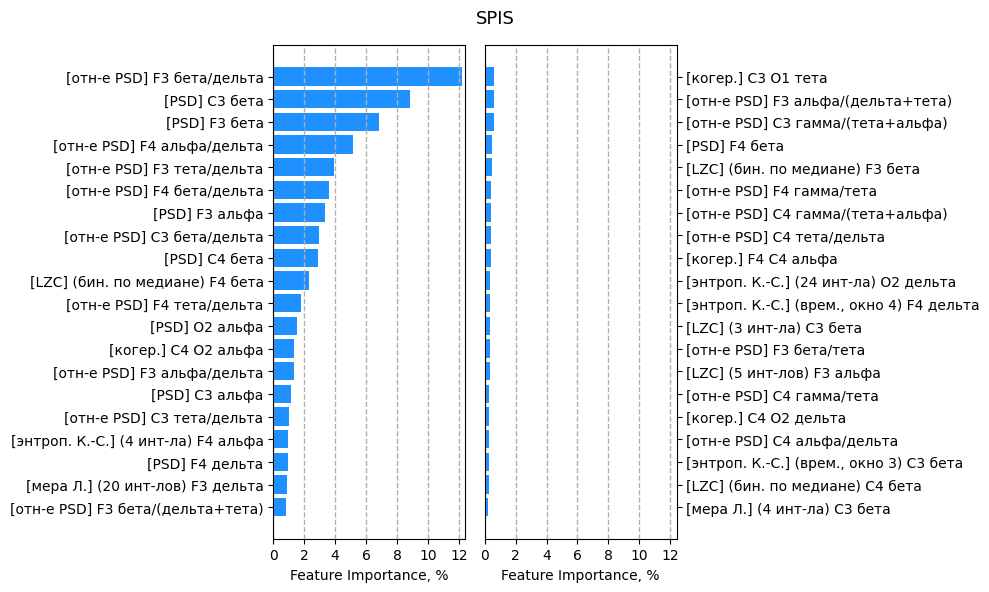

In [86]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 1, 2))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 1, 2))

# Настройка общего заголовка
plt.suptitle("SPIS", fontsize=13)

plt.tight_layout()
plt.savefig("plots/spis/feature_importance.png")
plt.show()

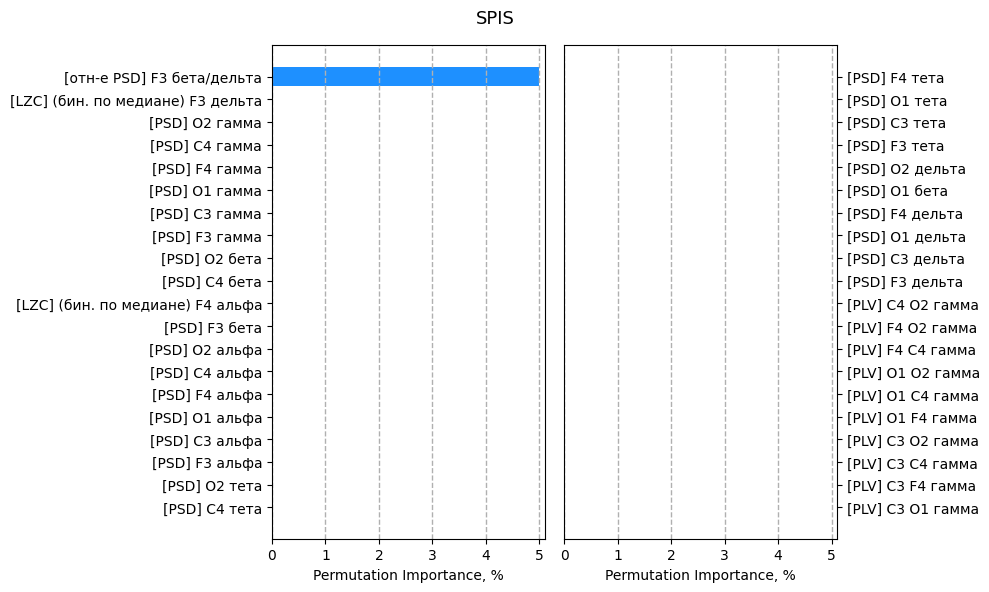

In [49]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Permutation Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.1])
ax1.set_xticks = np.arange(0, max(sorted_importance) + 0.1, 0.1)

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Permutation Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.1])
ax2.set_xticks = np.arange(0, max(sorted_importance) + 0.1, 0.1)

plt.suptitle("SPIS", fontsize=13)

plt.tight_layout()
plt.savefig("plots/spis/perm_importance.png")
plt.show()

Стадия: [1]


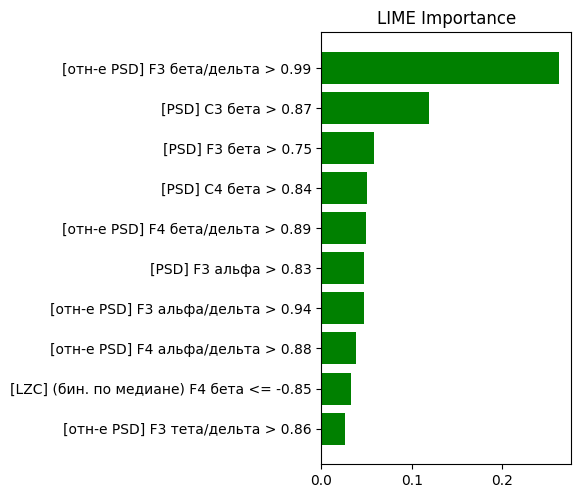

In [88]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = [X_test.sample(n=1, random_state=43)]
print(f"Стадия: {y_test[[random_samples[0].index[0]]]}")
# 0 - глаза открыты, 1 - закрыты

for sample in random_samples:
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance")
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/spis/lime.png")
    plt.show()

### MNIST

In [51]:
dfs = get_dataframes(
    "mnist",
    ["part2"]
)
len(dfs)

65

In [52]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    dfs,
    val_n=5,
    test_n=10
)

In [53]:
path = "models/mnist.bin"

if os.path.exists(path):
    print("pretrained")
    model = CatBoostClassifier()
    model.load_model(path)
else:
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        verbose=50
    )
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        # plot=True
    )
    model.save_model(path)

0:	learn: 2.3930858	test: 2.3932855	best: 2.3932855 (0)	total: 2.2s	remaining: 36m 36s
50:	learn: 2.2961237	test: 2.3133014	best: 2.3133014 (50)	total: 2m 24s	remaining: 44m 49s
100:	learn: 2.2688281	test: 2.3054397	best: 2.3054397 (100)	total: 4m 22s	remaining: 38m 52s
150:	learn: 2.2455124	test: 2.3044159	best: 2.3043868 (138)	total: 6m 14s	remaining: 35m 3s
200:	learn: 2.2219492	test: 2.3051269	best: 2.3043094 (155)	total: 8m 4s	remaining: 32m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.30430936
bestIteration = 155

Shrink model to first 156 iterations.


In [54]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.20      0.14       978
           1       0.12      0.09      0.10       960
           2       0.10      0.11      0.11      1010
           3       0.10      0.11      0.10      1060
           4       0.10      0.04      0.06       960
           5       0.11      0.13      0.12      1044
           6       0.09      0.08      0.08      1007
           7       0.12      0.07      0.09       960
           8       0.11      0.11      0.11      1006
           9       0.10      0.11      0.10      1015

    accuracy                           0.11     10000
   macro avg       0.11      0.11      0.10     10000
weighted avg       0.11      0.11      0.10     10000



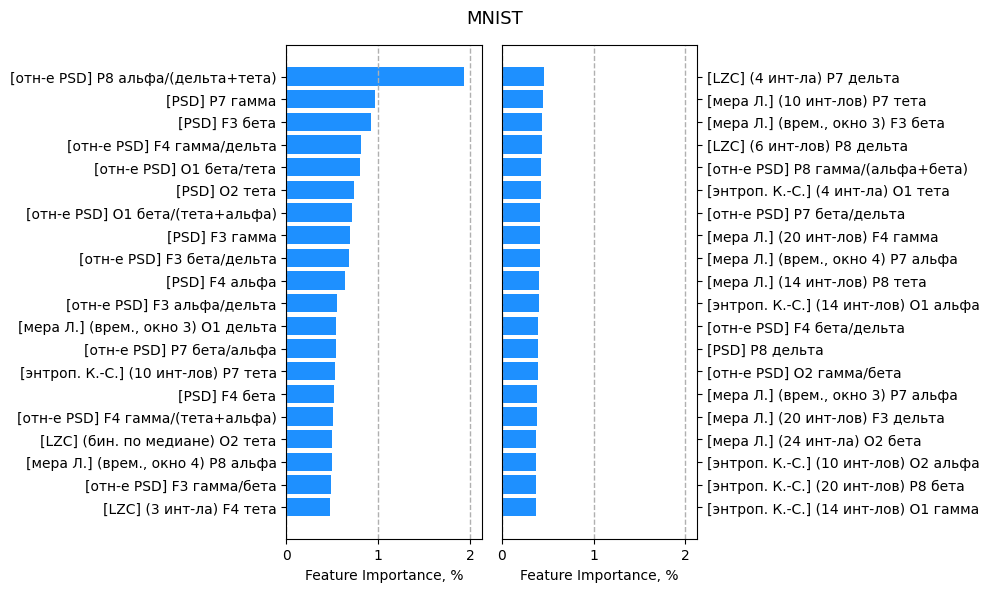

In [55]:
feature_importance = model.get_feature_importance()
total_importance = np.sum(feature_importance)
feature_importance = (feature_importance / total_importance) * 100

feature_names = translate_feature_names(model.feature_names_)

sorted_idx = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Feature Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.2])
ax1.set_xticks(range(0, int(max(sorted_importance)) + 2))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Feature Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.2])
ax2.set_xticks(range(0, int(max(sorted_importance)) + 2))

# Настройка общего заголовка
plt.suptitle("MNIST", fontsize=13)

plt.tight_layout()
plt.savefig("plots/mnist/feature_importance.png")
plt.show()

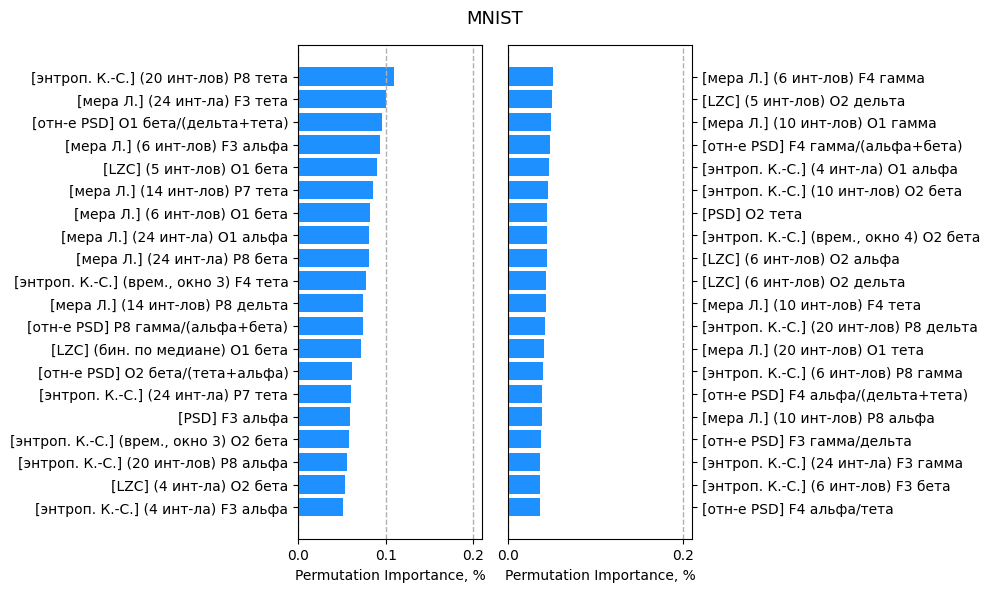

In [56]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = translate_feature_names(X_train.columns)
importance = perm_importance.importances_mean * 100

sorted_idx = importance.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(sorted_feature_names[:20], sorted_importance[:20], color='dodgerblue')
ax1.grid(True, axis='x', linestyle='--', linewidth=1)
ax1.set_xlabel('Permutation Importance, %')
ax1.invert_yaxis()
ax1.set_xlim([0, max(sorted_importance) + 0.1])
ax1.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.1))

ax2.barh(sorted_feature_names[20:40], sorted_importance[20:40], color='dodgerblue')
ax2.grid(True, axis='x', linestyle='--', linewidth=1)
ax2.set_xlabel('Permutation Importance, %')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', left=False, right=True)
ax2.set_xlim([0, max(sorted_importance) + 0.1])
ax2.set_xticks(np.arange(0, max(sorted_importance) + 0.1, 0.2))

plt.suptitle("MNIST", fontsize=13)

plt.tight_layout()
plt.savefig("plots/mnist/perm_importance.png")
plt.show()

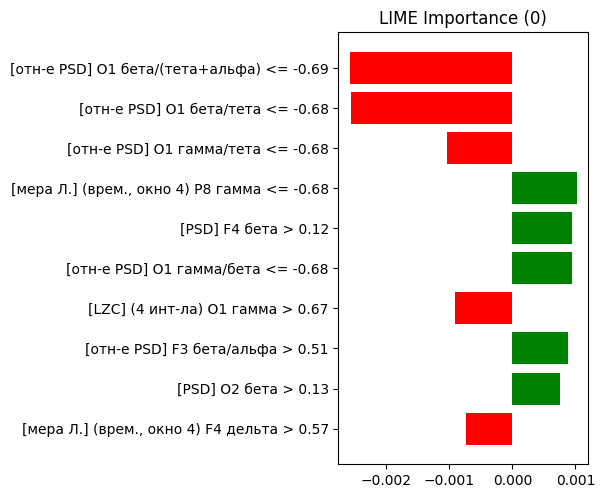

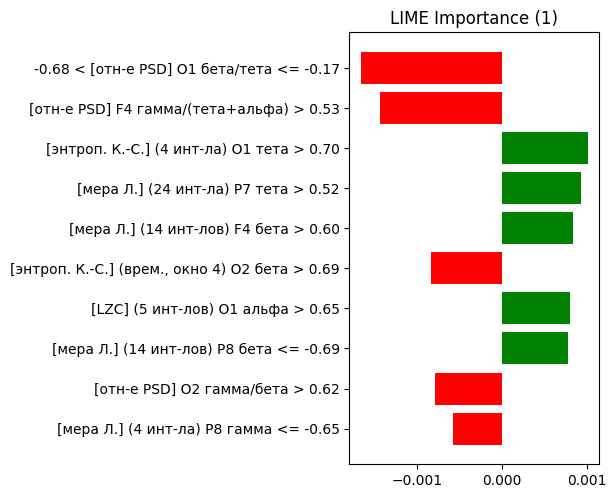

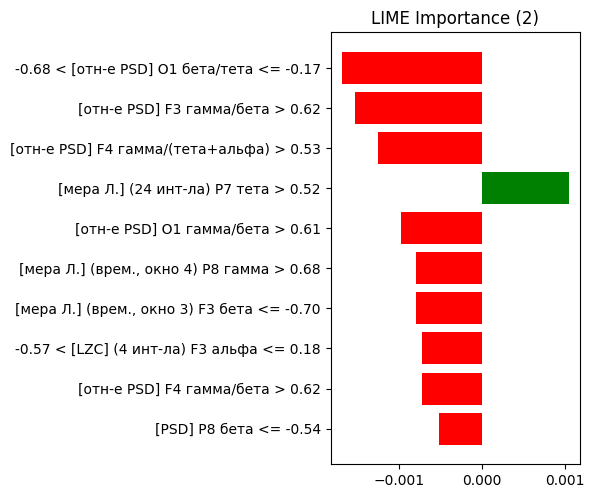

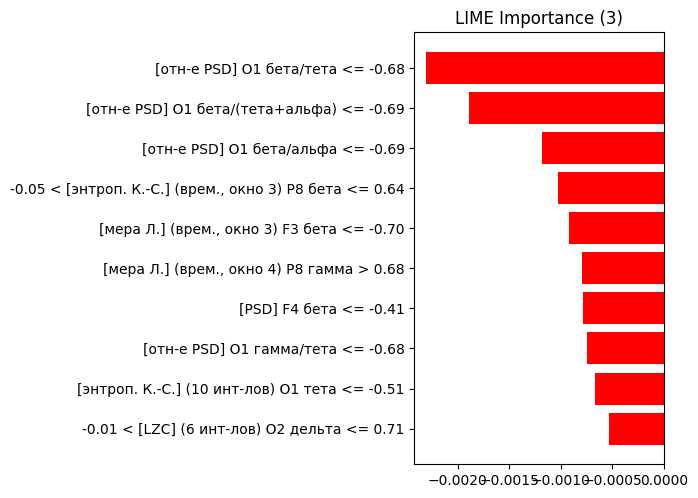

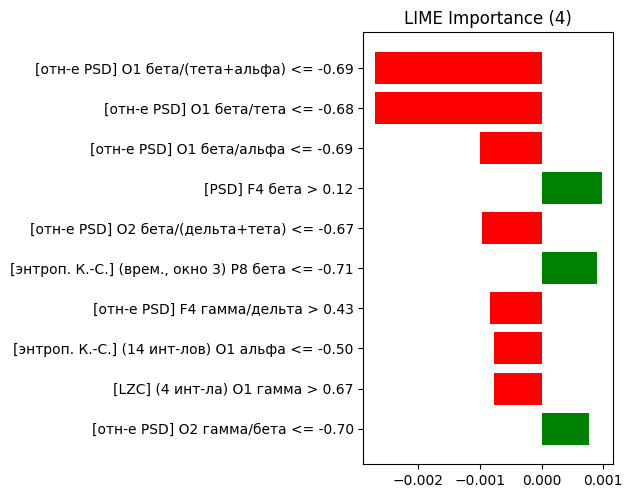

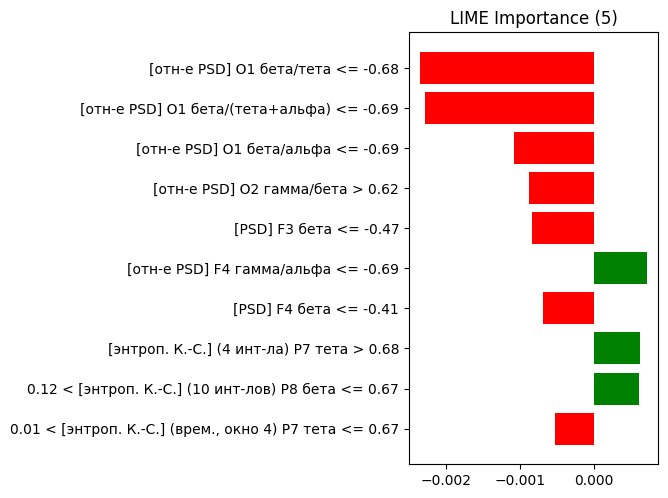

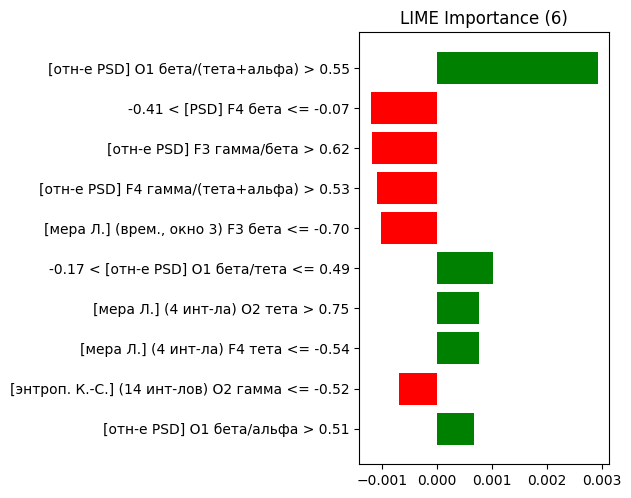

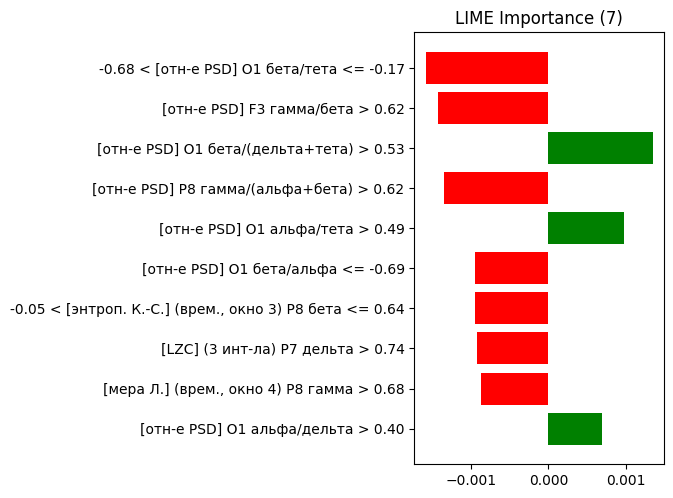

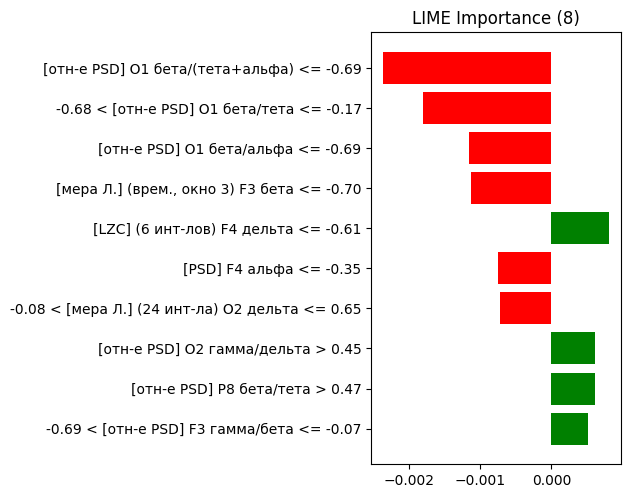

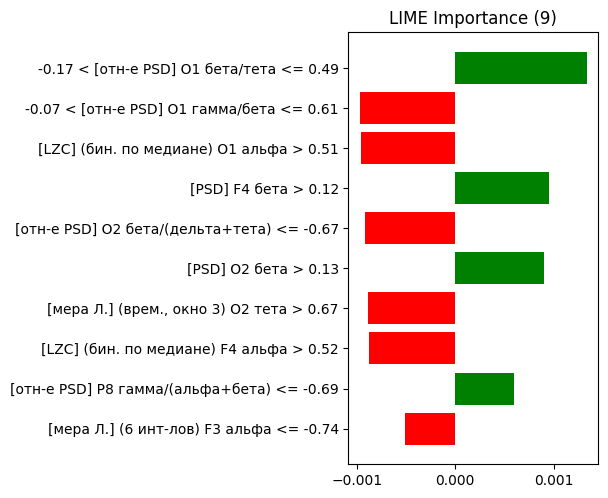

In [57]:
explainer = LimeTabularExplainer(X_train.values, feature_names=translate_feature_names(X_train.columns), mode='classification')

unique_classes = np.unique(y_pred)

random_samples = []
for class_label in unique_classes:
    class_samples = X_test[y_pred == class_label]
    random_sample = class_samples.sample(n=1, random_state=42)
    random_samples.append(random_sample)

for sample, stage in zip(
    random_samples,
    unique_classes
):
    exp = explainer.explain_instance(sample.values[0], model.predict_proba)
    exp.as_pyplot_figure()
    fig.set_size_inches(15, 6)
    plt.title(f"LIME Importance ({stage})")
    # plt.tight_layout()
    plt.subplots_adjust(left=0.6, right=0.99, top=0.95, bottom=0.05)
    plt.savefig(f"plots/mnist/lime-{stage}.png")
    plt.show()